In [24]:
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pandas as pd
import numpy as np
from tensorflow.keras.utils import plot_model

In [5]:
# Data Load
df = pd.read_csv('D:/Denoising/Autoencoder/LSTM_SAE/Samsung.txt', sep = ',')

In [10]:
# Normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['CLOSE']])
df["Close"] = scaled

In [11]:
# Make Time Series Data Set
size = 20
total_stock_list2 = np.zeros((len(df)-size+1,size,1))
count = 0
for i in range(len(df)-size+1):
    stock_list = np.zeros(shape = size)
    end_idx = i+size
    dff = df[i:end_idx]
    dff.reset_index(inplace = True)
    if len(dff)>=size:
        for j in range(size):
            stock_list2 = np.zeros(shape = 1)
            stock_list2[0] = dff["Close"][j]
            stock_list[j] = stock_list2
            
            total_stock_list2[count][j][0] = dff["Close"][j]            
        count += 1
    print("{} / {}".format(i+1, len(total_stock_list2)))
    
# Split Train and Test Set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(total_stock_list2, total_stock_list2, test_size=0.2, random_state=42)

1 / 1456
2 / 1456
3 / 1456
4 / 1456
5 / 1456
6 / 1456
7 / 1456
8 / 1456
9 / 1456
10 / 1456
11 / 1456
12 / 1456
13 / 1456
14 / 1456
15 / 1456
16 / 1456
17 / 1456
18 / 1456
19 / 1456
20 / 1456
21 / 1456
22 / 1456
23 / 1456
24 / 1456
25 / 1456
26 / 1456
27 / 1456
28 / 1456
29 / 1456
30 / 1456
31 / 1456
32 / 1456
33 / 1456
34 / 1456
35 / 1456
36 / 1456
37 / 1456
38 / 1456
39 / 1456
40 / 1456
41 / 1456
42 / 1456
43 / 1456
44 / 1456
45 / 1456
46 / 1456
47 / 1456
48 / 1456
49 / 1456
50 / 1456
51 / 1456
52 / 1456
53 / 1456
54 / 1456
55 / 1456
56 / 1456
57 / 1456
58 / 1456
59 / 1456
60 / 1456
61 / 1456
62 / 1456
63 / 1456
64 / 1456
65 / 1456
66 / 1456
67 / 1456
68 / 1456
69 / 1456
70 / 1456
71 / 1456
72 / 1456
73 / 1456
74 / 1456
75 / 1456
76 / 1456
77 / 1456
78 / 1456
79 / 1456
80 / 1456
81 / 1456
82 / 1456
83 / 1456
84 / 1456
85 / 1456
86 / 1456
87 / 1456
88 / 1456
89 / 1456
90 / 1456
91 / 1456
92 / 1456
93 / 1456
94 / 1456
95 / 1456
96 / 1456
97 / 1456
98 / 1456
99 / 1456
100 / 1456
101 / 14

In [12]:
# Build Model
model = keras.Sequential()

timestamp = total_stock_list2.shape[1]
features = total_stock_list2.shape[2]

# Encoder LSTM cell1
model.add(keras.layers.LSTM(units=20, input_shape=(timestamp, features), return_sequences = True))
model.add(keras.layers.Dropout(rate=0.2))

# Encoder LSTM cell2
model.add(keras.layers.LSTM(units=15, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))

# Encoder LSTM cell3
model.add(keras.layers.LSTM(units=10, return_sequences=False))
model.add(keras.layers.Dropout(rate=0.2))

model.add(keras.layers.RepeatVector(timestamp))

# Decoder LSTM cell1
model.add(keras.layers.LSTM(units=10, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))

# Decoder LSTM cell2
model.add(keras.layers.LSTM(units=15, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))

# Decoder LSTM cell3
model.add(keras.layers.LSTM(units=20, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))

model.add(keras.layers.TimeDistributed(keras.layers.Dense(features)))
model.compile(loss='mse', optimizer = Adam(learning_rate = 0.0001))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 20)            1760      
                                                                 
 dropout (Dropout)           (None, 20, 20)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 15)            2160      
                                                                 
 dropout_1 (Dropout)         (None, 20, 15)            0         
                                                                 
 lstm_2 (LSTM)               (None, 10)                1040      
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 20, 10)           0

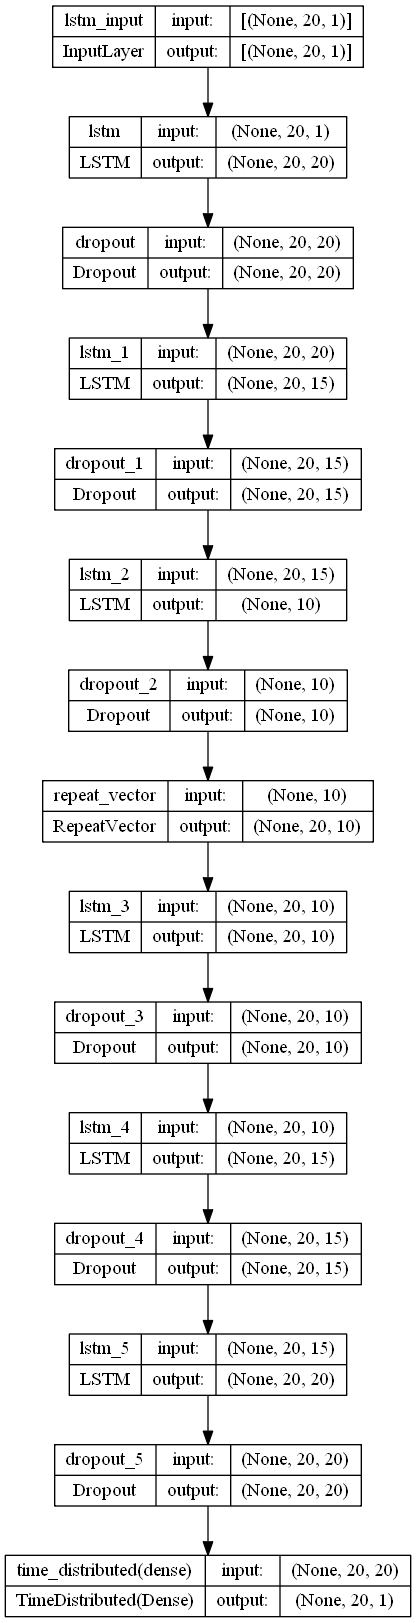

In [25]:
plot_model(model, to_file='model_shapes.png', show_shapes=True)

In [13]:
# Train Model
history = model.fit(x_train, y_train, epochs=500, batch_size=10,validation_split=0.1,shuffle=True)

Epoch 1/500
105/105 [==============================] - 23s 67ms/step - loss: 0.1745 - val_loss: 0.0818
Epoch 2/500
105/105 [==============================] - 3s 33ms/step - loss: 0.0828 - val_loss: 0.0575
Epoch 3/500
105/105 [==============================] - 3s 32ms/step - loss: 0.0672 - val_loss: 0.0446
Epoch 4/500
105/105 [==============================] - 4s 39ms/step - loss: 0.0518 - val_loss: 0.0336
Epoch 5/500
105/105 [==============================] - 4s 33ms/step - loss: 0.0416 - val_loss: 0.0262
Epoch 6/500
105/105 [==============================] - 4s 34ms/step - loss: 0.0343 - val_loss: 0.0218
Epoch 7/500
105/105 [==============================] - 4s 35ms/step - loss: 0.0301 - val_loss: 0.0192
Epoch 8/500
105/105 [==============================] - 3s 32ms/step - loss: 0.0268 - val_loss: 0.0175
Epoch 9/500
105/105 [==============================] - 4s 34ms/step - loss: 0.0245 - val_loss: 0.0160
Epoch 10/500
105/105 [==============================] - 3s 33ms/step - loss: 0.02

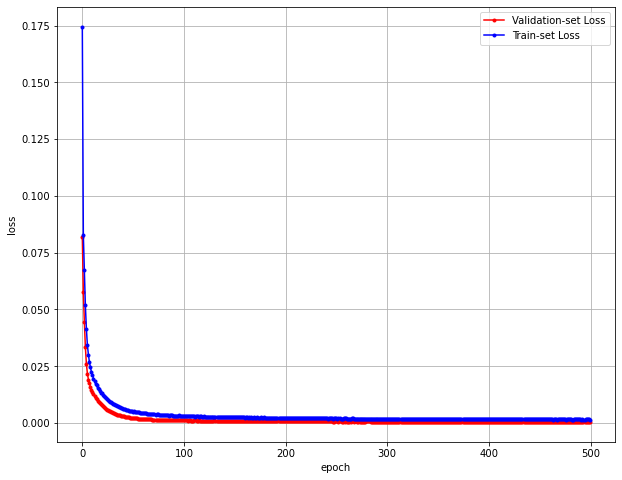

In [15]:
# Check Loss
plt.figure(figsize = (10,8))
y_vloss = history.history["val_loss"]
y_loss = history.history["loss"]

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c ='red', label = 'Validation-set Loss')
plt.plot(x_len, y_loss, marker='.', c ='blue', label = 'Train-set Loss')


plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [17]:
# Predict
pred = model.predict(total_stock_list2)

# Sum window size units
mean_list = [0 for i in range(len(df))]
for i in range(len(total_stock_list2)):
    for j in range(20):
        mean_list[i+j] += pred[i][j]

# Calculate average
mean_list2= []
count = 19
for i in range(len(mean_list)):
    if i < 20:
        mean_list2.append(mean_list[i] / (i+1))
    elif i >=20 and (i <= len(mean_list)-20):
        mean_list2.append(mean_list[i] / 20)
    else:
        mean_list2.append(mean_list[i] / count)
        count -= 1


46/46 [==============================] - 1s 7ms/step


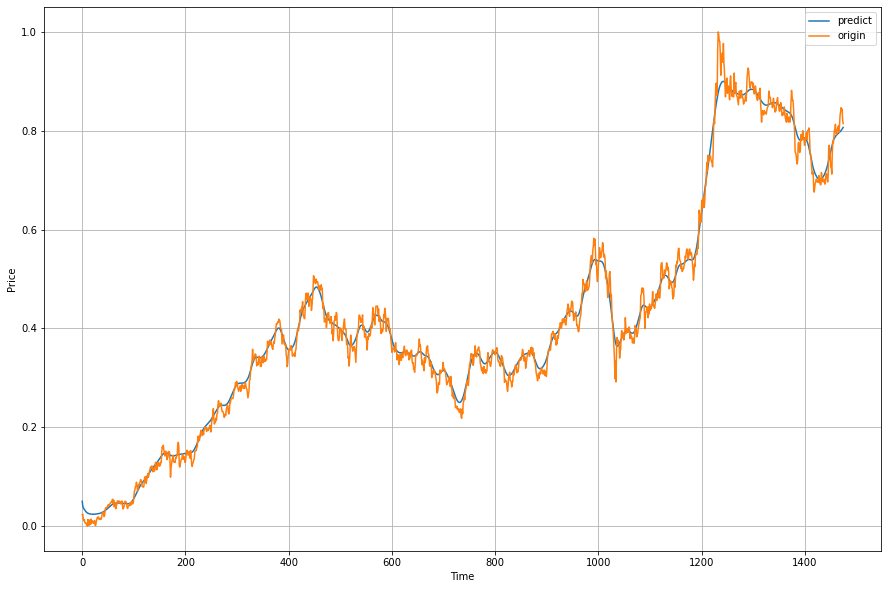

In [22]:
# Compare origin and prediction
st_price = []
for i in range(len(df["Close"])):
    st_price.append(df["Close"][i])

plt.figure(figsize = (15,10))
plt.plot(mean_list2, label = 'predict')
plt.plot(st_price, label = 'origin')
plt.grid()
plt.legend(loc ='upper right')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()